<a href="https://colab.research.google.com/github/DyanielCX/DLI-Assm/blob/main/Dyaniel_CL_K_Means_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import All Dependencies & Libraries

In [25]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
from skopt import BayesSearchCV
from skopt.space import Integer
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


## Data Prepocessing

In [26]:
# Importing the dataset from GitHub
github_csv_url = 'https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv'
raw_dataset = pd.read_csv(github_csv_url)

''' Dataset for Deep Learning '''
# Copy the raw dataset with only 'url' and 'status' columns
DL_dataset = raw_dataset[['url', 'status']].copy()
DL_dataset['url'] = DL_dataset['url'].str.lower()


''' Dataset for Machine Learning '''
# Copy the raw dataset
ML_dataset = raw_dataset.copy()

# Drop the URL columns (ML only need numeric vectors data)
if 'url' in ML_dataset.columns:
    ML_dataset = ML_dataset.drop(columns=['url'])


## Model Training


### RNN Deep Learning Model

In [27]:
# Set start time for recording the model training time
train_start_time = time.time()

# Encode status column
label_encoder = LabelEncoder()
DL_dataset['status'] = label_encoder.fit_transform(DL_dataset['status'])

# Tokenize URLs for RNN
urls = DL_dataset['url'].astype(str).values
labels = DL_dataset['status'].values

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
max_len = 200
X_padded = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build RNN model
input_layer = Input(shape=(max_len,))
embedding = Embedding(input_dim=vocab_size, output_dim=32)(input_layer)
rnn_output = SimpleRNN(64, return_sequences=False, name="rnn_features")(embedding)
output = Dense(1, activation='sigmoid')(rnn_output)

RNN_model = Model(inputs=input_layer, outputs=output)
RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train RNN with custom settings
RNN_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate RNN model
loss, accuracy = RNN_model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {round(accuracy * 100, 2)}%")

# Predict on test set
predictions = RNN_model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)
print(f"\n🔢 First 10 Predictions: {predicted_labels[:10].flatten()}")
print(f"🧾 First 10 True Labels: {y_test[:10]}")


Epoch 1/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.6208 - loss: 0.6336 - val_accuracy: 0.8054 - val_loss: 0.4246
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7919 - loss: 0.4485 - val_accuracy: 0.8048 - val_loss: 0.4283
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.8237 - loss: 0.3979 - val_accuracy: 0.8360 - val_loss: 0.3812
Epoch 4/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8300 - loss: 0.3913 - val_accuracy: 0.8354 - val_loss: 0.3739
Epoch 5/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8288 - loss: 0.3948 - val_accuracy: 0.8179 - val_loss: 0.3981
Epoch 6/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8538 - loss: 0.3486 - val_accuracy: 0.8469 - val_loss: 0.3639
Epoch 7/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8555 - loss: 0.3365 - val_accuracy: 0.8425 - val_loss: 0.3666
Epoch 8/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8700 - loss: 0.3202 - 

### Extract RNN Embeddings

In [28]:
# Create a new model that outputs the RNN layer
feature_extractor = Model(
    inputs=RNN_model.input,
    outputs=RNN_model.get_layer("rnn_features").output  # 'rnn_features' is the layer name
)

try:
    # Apply it on the full padded URL input
    rnn_features = feature_extractor.predict(X_padded)

    # Convert to DataFrame
    rnn_feature_df = pd.DataFrame(
        rnn_features,
        columns=[f"rnn_feat_{i}" for i in range(rnn_features.shape[1])]
    )
except Exception as e:
    print(f"❌ An error occurred during RNN feature extraction: {e}")
finally:
    print("✅ RNN feature extraction process done.")

358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
✅ RNN feature extraction process done.


### Scaling ML Dataset & Merge with RNN Output

In [29]:
try:
  # Drop "status" column and reset index
  ml_only = ML_dataset.drop(columns=['status']).reset_index(drop=True)

  # Standardize ML features
  scaler = StandardScaler()
  ml_scaled = scaler.fit_transform(ml_only)
  ml_scaled_df = pd.DataFrame(ml_scaled, columns=ml_only.columns)

  # Combine with RNN features
  combined_features = pd.concat([ml_scaled_df, rnn_feature_df], axis=1)

  # Reattach "status" column
  ML_combined_dataset = combined_features.copy()
  ML_combined_dataset['status'] = ML_dataset['status'].reset_index(drop=True)

except Exception as e:
    print(f"❌ An error occurred during ML dataset merging: {e}")
finally:
    print("✅ ML dataset merging done.")
    print("Final merged and scaled dataset shape:", ML_dataset.shape)

✅ ML dataset merging done.
Final merged and scaled dataset shape: (11430, 88)


### Cluster-Labeling K-Means (CL_K-Means) Machine Learning

In [30]:
X = ML_combined_dataset.drop(columns=['status'])
y = ML_combined_dataset['status']

# Find the Best k using BO-TPE (Bayesian Optimization)
search_space = {'n_clusters': Integer(2, 10)}
opt_kmeans = BayesSearchCV(KMeans(random_state=42), search_space, n_iter=10, cv=3, scoring='accuracy', verbose=0)
opt_kmeans.fit(X, y)
best_k = opt_kmeans.best_params_['n_clusters']
print(f"✅ Best k found by BO-TPE: {best_k}")

# Train CL-KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X)

# Map clusters to true labels using majority voting
mapped_labels = np.zeros_like(clusters)
for i in range(best_k):
    mask = (clusters == i)
    mapped_labels[mask] = mode(y[mask])[0]


✅ Best k found by BO-TPE: 3


### Bias Correction with Random Forest


✅ Bias-Corrected Accuracy: 96.41 %

📊 Classification Report (Bias-Corrected):
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       972
           1       0.95      0.99      0.97      1314

    accuracy                           0.96      2286
   macro avg       0.97      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286



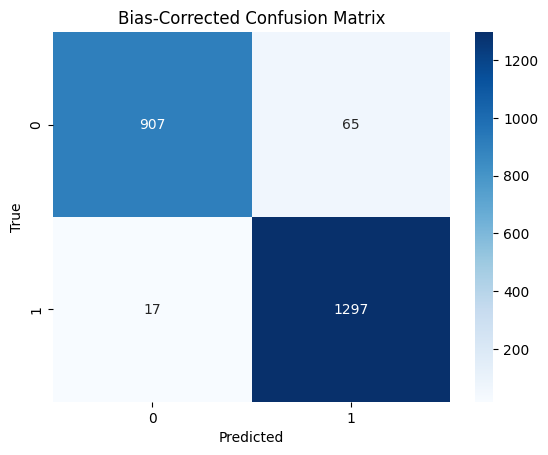

In [31]:
# Train Random Forest for Bias Correction
X_train, X_test, y_train, y_test = train_test_split(X, mapped_labels, test_size=0.2, stratify=y, random_state=42)
bias_corrector = RandomForestClassifier(random_state=42)
bias_corrector.fit(X_train, y_train)
corrected_preds = bias_corrector.predict(X_test)
print("\n✅ Bias-Corrected Accuracy:", round(accuracy_score(y_test, corrected_preds) * 100, 2), "%")

# Get the model training time
training_time = time.time() - train_start_time

# Evaluate Bias-Corrected Classifier
print("\n📊 Classification Report (Bias-Corrected):")
print(classification_report(y_test, corrected_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, corrected_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Bias-Corrected Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Bias Correction Model Evaluation Metrics

In [42]:
# Calculate Prediction Time
pred_start_time = time.time()
corrected_preds = bias_corrector.predict(X_test)
prediction_time = time.time() - pred_start_time

# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, corrected_preds)
precision = precision_score(y_test, corrected_preds, average='weighted')
recall = recall_score(y_test, corrected_preds, average='weighted')
f1 = f1_score(y_test, corrected_preds, average='weighted')


print(f"✅ Bias-Corrected Accuracy: {round(accuracy * 100, 2)}%")
print(f"✅ Bias-Corrected Precision: {round(precision * 100, 2)}%")
print(f"✅ Bias-Corrected Recall: {round(recall * 100, 2)}%")
print(f"✅ Bias-Corrected F1-score: {round(f1 * 100, 2)}%")
# print(f"✅ RNN Model Trainable Parameters: {RNN_model.count_params()}")
# print(f"✅ Training Time: {round(training_time, 4)} seconds")
# print(f"✅ Prediction Time: {round(prediction_time, 4)} seconds")
print(f"✅ Training Time: {round(training_time / 60, 4)} minutes")
print(f"✅ Prediction Time: {round(prediction_time * 1000, 4)} milliseconds")


✅ Bias-Corrected Accuracy: 96.41%
✅ Bias-Corrected Precision: 96.47%
✅ Bias-Corrected Recall: 96.41%
✅ Bias-Corrected F1-score: 96.4%
✅ RNN Model Trainable Parameters: 8641
✅ Training Time: 5.7823 minutes
✅ Prediction Time: 41.1572 milliseconds


## Model Performance Comparison

### Prepare data for plotting


In [39]:
# Manual set the reseacher's model performance evaluation
RP_accuracy = 93.04
RP_percision = 86.53
RP_recall = 93.04
RP_f1 = 89.32
RP_P_time = 14
RP_T_time = 2.64

# Prepare performance metrics
performance_metrics = {
    'My Model': {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Training Time (minutes)': training_time / 60,
        'Prediction Time (milliseconds)': prediction_time * 1000
    },
    'Researcher\'s Model': {
        'Accuracy': RP_accuracy / 100,
        'Precision': RP_percision / 100,
        'Recall': RP_recall / 100,
        'F1-score': RP_f1 / 100,
        'Training Time (minutes)': RP_T_time,
        'Prediction Time (milliseconds)': RP_P_time
    }
}

df_performance = pd.DataFrame(performance_metrics)

### Create comparison plots

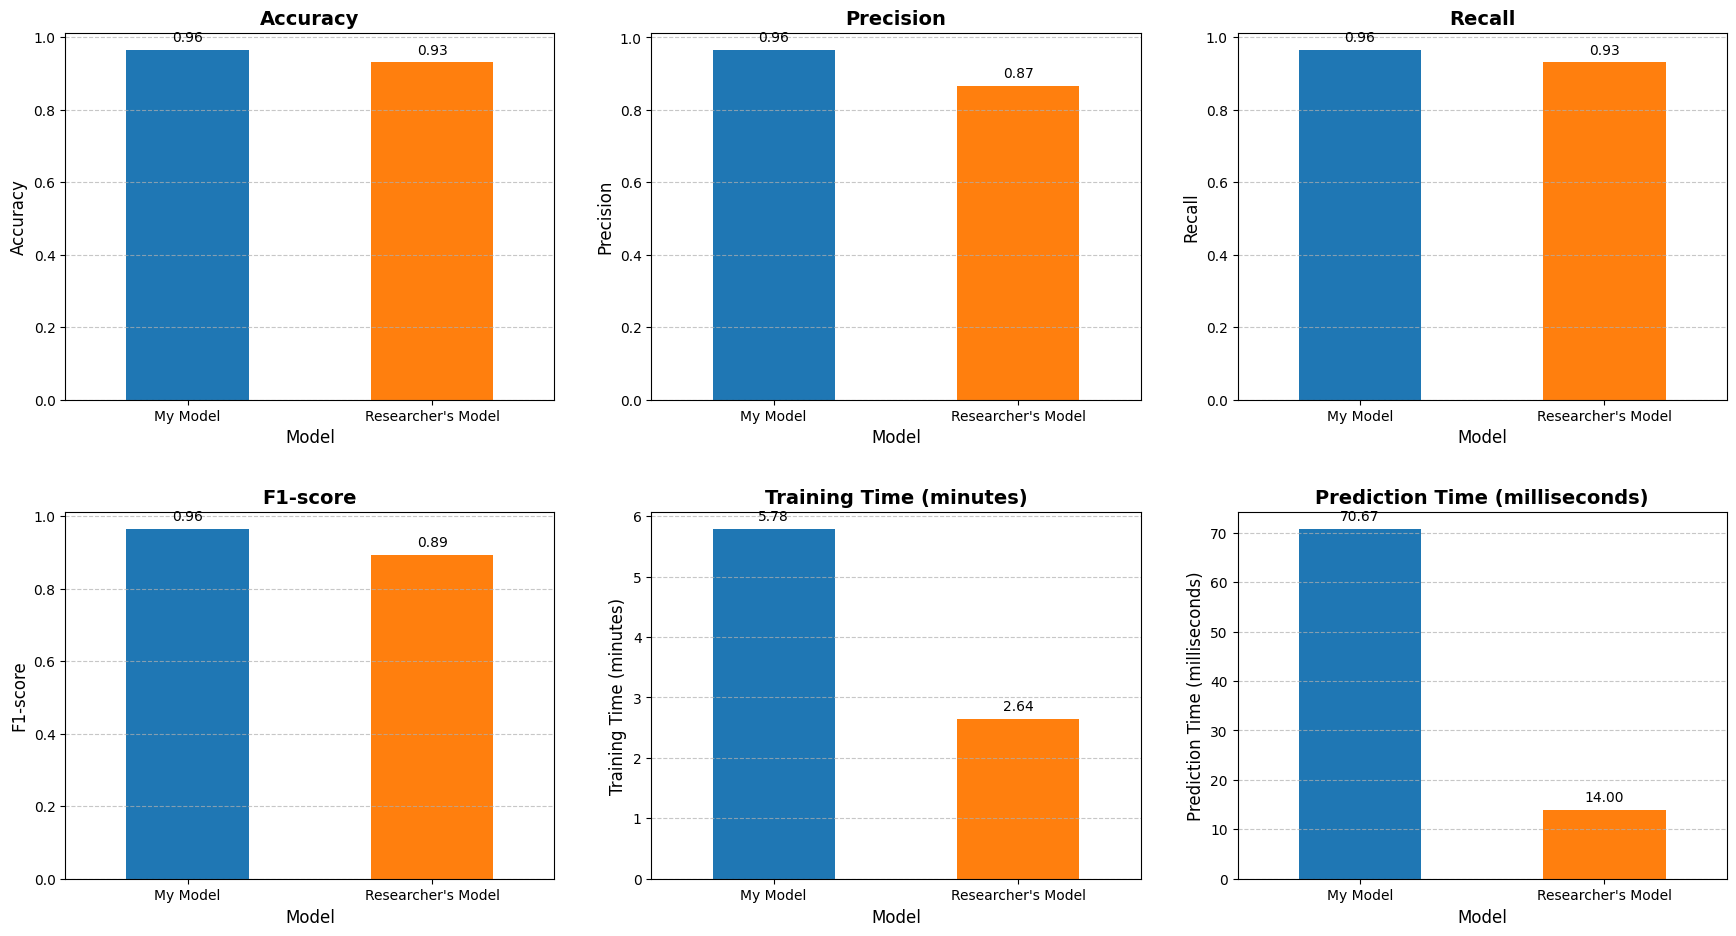

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = df_performance.index.tolist()
colors = ['#1f77b4', '#ff7f0e']

for i, metric in enumerate(metrics):
    ax = axes[i]
    df_performance.loc[metric].plot(kind='bar', ax=ax, rot=0, color=colors)
    ax.set_title(f"{metric}", fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel("Model", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=10)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

# # Display models performance in table
# display(df_performance)